In [ ]:
#pip install keras_preprocessing

Note: you may need to restart the kernel to use updated packages.


  Cache entry deserialization failed, entry ignored
  The script f2py.exe is installed in 'c:\Users\padawan\AppData\Local\Programs\Python\Python37\Scripts' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You are using pip version 10.0.1, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# Загрузка необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
#from tensorflow.keras.layers.experimental import preprocessing
from pathlib import Path
import os.path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Загружаем данные для обучения тестирования и проверки

In [3]:
train = r'D:\my_space\mifi_ml\hakaton1\final dataset used for oil spill\dataset-final\dataset\train'
validation = r'D:\my_space\mifi_ml\hakaton1\final dataset used for oil spill\dataset-final\dataset\Validation'
test =r'D:\my_space\mifi_ml\hakaton1\final dataset used for oil spill\dataset-final\dataset\test'

# Читаем тренировочные данные 

In [4]:
# Directories for Non Oil Spill and Oil Spill images
non_oil_spill_dir = os.path.join(train, 'Non Oil Spill')
oil_spill_dir = os.path.join(train, 'Oil Spill')


In [5]:
labels = ['Non Oil Spill', 'Oil Spill']

for label in labels:
    path = os.path.join( train)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_arr = cv2.imread(img_path)

        if img_arr is not None:
            print(f"Original size of image {img}: {img_arr.shape}") 

# Меняем размер изображений на 150

In [6]:
labels = ['Non Oil Spill', 'Oil Spill']
img_size = 150
data = []

for label in labels: 
    path = os.path.join(train, label)  
    class_num = labels.index(label)

    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_arr = cv2.imread(img_path)

        if img_arr is not None: 
            img_arr = cv2.resize(img_arr, (img_size, img_size))  
            data.append([img_arr, class_num])  


# Примеры изображений

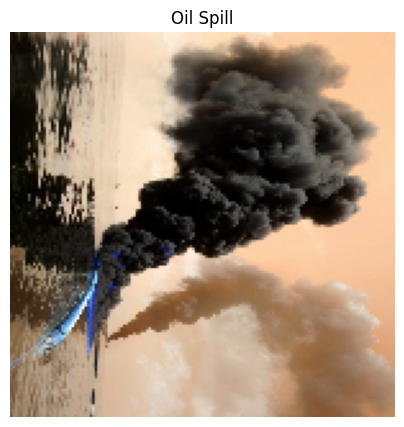

Size of image 1: (150, 150, 3)


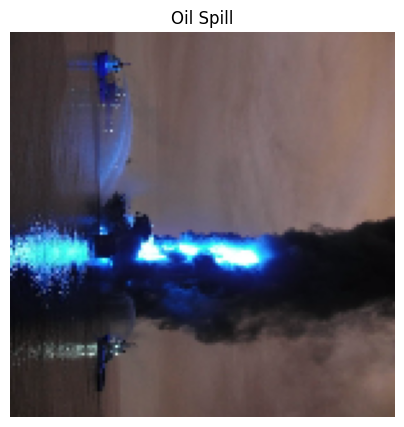

Size of image 2: (150, 150, 3)


In [7]:
count=0
for i in range(len(data)):
    if data[i][1] == 1: 
        plt.figure(figsize=(5, 5))
        plt.imshow(data[i][0])  
        plt.title(labels[data[i][1]])  
        plt.axis('off')  
        plt.show()
        
        print(f"Size of image {count + 1}: {data[i][0].shape}")
        
        count += 1  
        
        if count == 2:  
            break

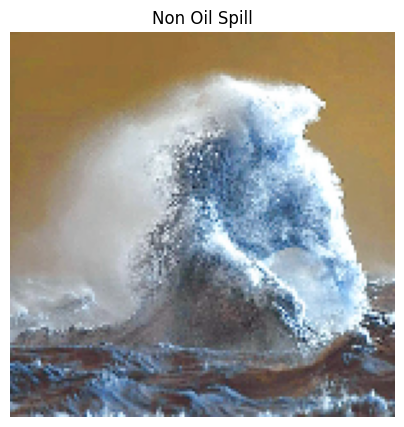

Size of image 1: (150, 150, 3)


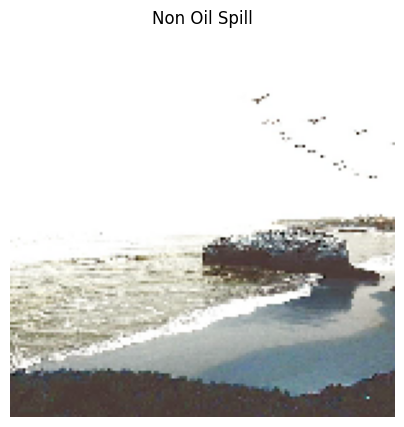

Size of image 2: (150, 150, 3)


In [8]:
data = np.array(data, dtype=object)

for i in range(2):
    plt.figure(figsize=(5, 5))
    plt.imshow(data[i][0])  
    plt.title(labels[data[i][1]])  
    plt.axis('off')  
    plt.show()
    
    print(f"Size of image {i + 1}: {data[i][0].shape}")


# Создаём функциою для ресайзинга изображений 

In [9]:
def load_data(directory):
    data = []
    for label in labels: 
        path = os.path.join(directory, label)  
        class_num = labels.index(label)

        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            img_arr = cv2.imread(img_path)

            if img_arr is not None: 
                img_arr = cv2.resize(img_arr, (img_size, img_size))  
                data.append([img_arr, class_num])  
    return np.array(data, dtype=object)

In [10]:
train_data = load_data(train)
test_data = load_data(test)
validation_data = load_data(validation)

In [11]:
print("Shape of training data:", train_data.shape)
print("Shape of test data:", test_data.shape)
print("Shape of valdata:", validation_data.shape)

Shape of training data: (2800, 2)
Shape of test data: (600, 2)
Shape of valdata: (600, 2)


In [12]:
# Function to populate features and labels from data
def populate_data(data):
    features, labels = zip(*data) 
    return np.array(features) / 255.0, np.array(labels) 

# Разбиваем данные на тренировочные, валидационные и проверочные

In [13]:
x_train, y_train = populate_data(train_data)
x_val, y_val = populate_data(load_data(validation))  
x_test, y_test = populate_data(load_data(test))    

In [14]:
print("Shapes:")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

Shapes:
x_train: (2800, 150, 150, 3), y_train: (2800,)
x_val: (600, 150, 150, 3), y_val: (600,)
x_test: (600, 150, 150, 3), y_test: (600,)


# Проводим аугментацию данных.

In [16]:
datagen = ImageDataGenerator(
    rotation_range=90,          
    width_shift_range=0.2,      
    height_shift_range=0.2,     
    horizontal_flip=True         
)

In [17]:
datagen.fit(x_train)
datagen.fit(x_val)
datagen.fit(x_test)

# Базовая модель

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 1)                 175233    
                                                                 
Total params: 176,129
Trainable params: 176,129
Non-trainable params: 0
_________________________________________________________________


# Обучаем базовую модель

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), shuffle=True, batch_size=64)


Epoch 1/10
44/44 [==============================] - 6s 122ms/step - loss: 1.2970 - accuracy: 0.6039 - val_loss: 0.5189 - val_accuracy: 0.7450
Epoch 2/10
44/44 [==============================] - 5s 118ms/step - loss: 0.3125 - accuracy: 0.8954 - val_loss: 0.2775 - val_accuracy: 0.9033
Epoch 3/10
44/44 [==============================] - 5s 119ms/step - loss: 0.1546 - accuracy: 0.9571 - val_loss: 0.2644 - val_accuracy: 0.8833
Epoch 4/10
44/44 [==============================] - 5s 120ms/step - loss: 0.0957 - accuracy: 0.9807 - val_loss: 0.1281 - val_accuracy: 0.9567
Epoch 5/10
44/44 [==============================] - 6s 129ms/step - loss: 0.0620 - accuracy: 0.9879 - val_loss: 0.0973 - val_accuracy: 0.9633
Epoch 6/10
44/44 [==============================] - 6s 143ms/step - loss: 0.0452 - accuracy: 0.9907 - val_loss: 0.0859 - val_accuracy: 0.9667
Epoch 7/10
44/44 [==============================] - 6s 143ms/step - loss: 0.0348 - accuracy: 0.9954 - val_loss: 0.0645 - val_accuracy: 0.9817
Epoch 

# Визуализируем метрики точности и потерь

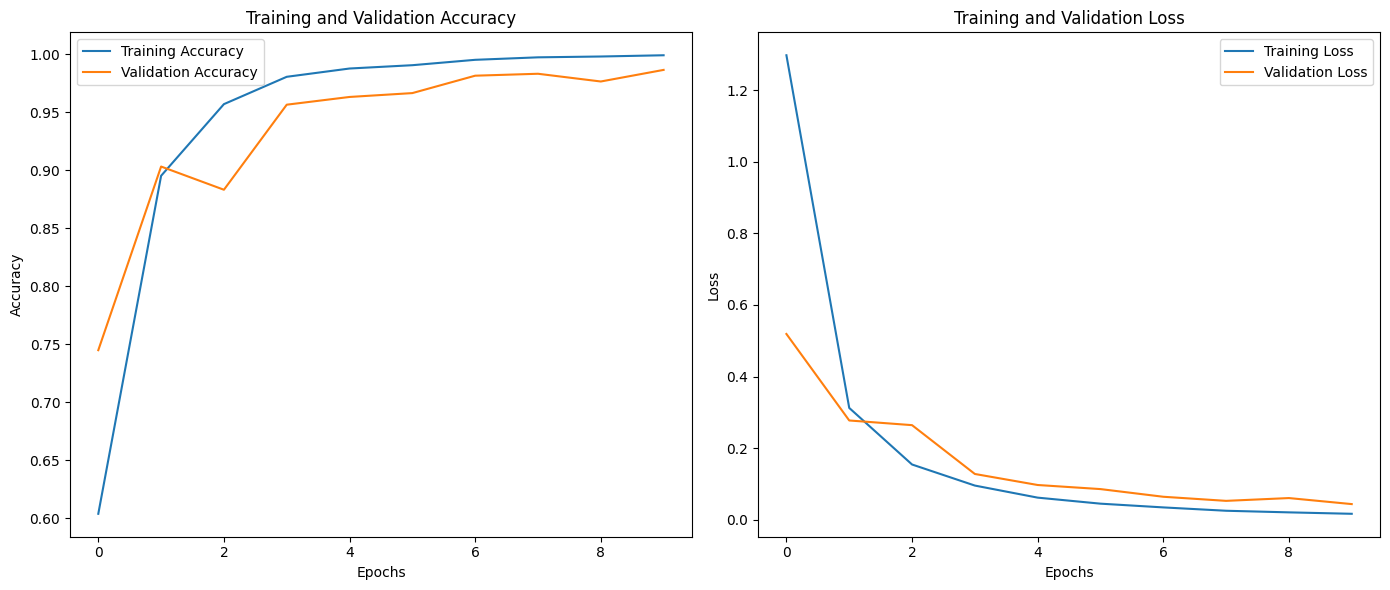

In [20]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(train_accuracy, label='Training Accuracy')
ax1.plot(val_accuracy, label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(train_loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()


# Выводим статистику по модели

In [21]:
from sklearn.metrics import classification_report
y_pred_test = (model.predict(x_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred_test))


19/19 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       300
           1       1.00      0.98      0.99       300

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



In [22]:
model.evaluate(x_test,y_test,batch_size=64)

10/10 [==============================] - 0s 26ms/step - loss: 0.0331 - accuracy: 0.9900


[0.03305577486753464, 0.9900000095367432]

# Создаём более сложную модель модель

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D

model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3), padding="same"))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))


model.add(Dense(1, activation="sigmoid"))

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 18, 18, 128)     

# Обучаем более сложную модель

In [39]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), shuffle=True, batch_size=64)


Epoch 1/20
44/44 [==============================] - 19s 435ms/step - loss: 0.6257 - accuracy: 0.6664 - val_loss: 0.5689 - val_accuracy: 0.7300
Epoch 2/20
44/44 [==============================] - 21s 478ms/step - loss: 0.4465 - accuracy: 0.7900 - val_loss: 0.4066 - val_accuracy: 0.8067
Epoch 3/20
44/44 [==============================] - 22s 502ms/step - loss: 0.2826 - accuracy: 0.8793 - val_loss: 0.3078 - val_accuracy: 0.8567
Epoch 4/20
44/44 [==============================] - 22s 500ms/step - loss: 0.1832 - accuracy: 0.9350 - val_loss: 0.2247 - val_accuracy: 0.9017
Epoch 5/20
44/44 [==============================] - 22s 495ms/step - loss: 0.1288 - accuracy: 0.9536 - val_loss: 0.2388 - val_accuracy: 0.8867
Epoch 6/20
44/44 [==============================] - 22s 490ms/step - loss: 0.0947 - accuracy: 0.9693 - val_loss: 0.1500 - val_accuracy: 0.9300
Epoch 7/20
44/44 [==============================] - 22s 491ms/step - loss: 0.0740 - accuracy: 0.9750 - val_loss: 0.1151 - val_accuracy: 0.9483

# Выводим статистику по модели

In [40]:
y_pred_test = (model.predict(x_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred_test))


19/19 [==============================] - 1s 38ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       300
           1       1.00      0.99      0.99       300

    accuracy                           0.99       600
   macro avg       1.00      0.99      0.99       600
weighted avg       1.00      0.99      0.99       600



# Визуализируем метрики точности и потерь

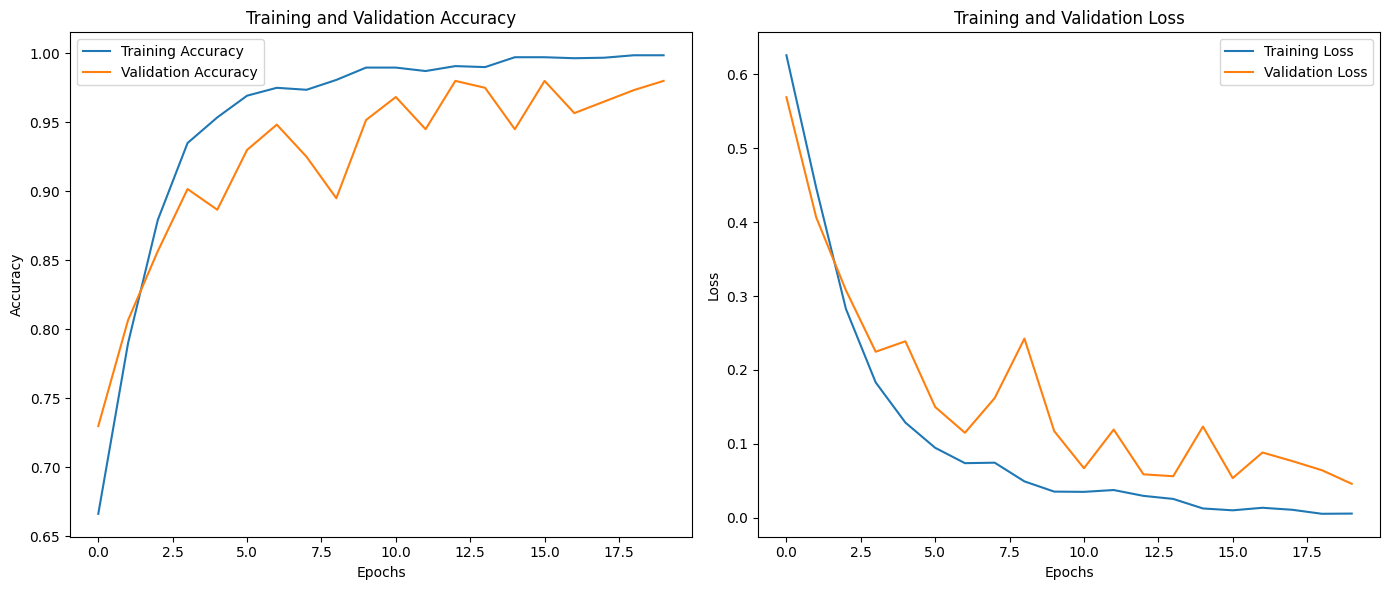

In [41]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(train_accuracy, label='Training Accuracy')
ax1.plot(val_accuracy, label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(train_loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()


# Предсказание и проверка работоспособности модели

In [42]:
import numpy as np
from PIL import Image
from tensorflow.keras.utils import img_to_array

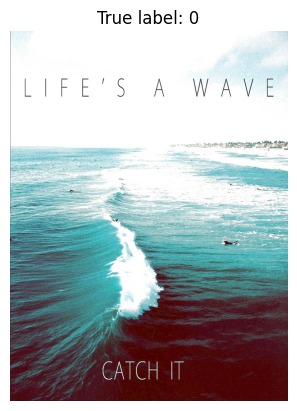

In [43]:
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = img_to_array(img) / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  #
    return img_array

# Path to your image and its true label
image_path = r'D:\my_space\mifi_ml\hakaton1\final dataset used for oil spill\dataset-final\dataset\test\Non Oil Spill/AUG_Non_oil_spill00150.jpg'  # Replace with your image path
true_label = 0 
plt.imshow(Image.open(image_path))
plt.axis('off')  # Hide the axis
plt.title(f"True label: {true_label}")
plt.show()

In [44]:
processed_image = load_and_preprocess_image(image_path)
prediction = model.predict(processed_image)
predicted_class = (prediction > 0.5).astype("int32")  
print("Predicted class:", predicted_class[0][0])



1/1 [==============================] - 0s 15ms/step
Predicted class: 0


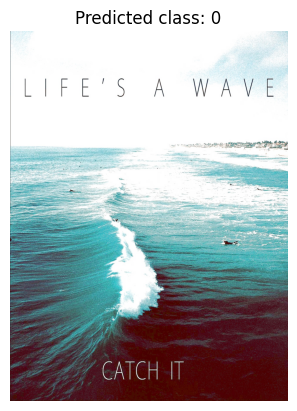

In [45]:
# Display the image
plt.imshow(Image.open(image_path))
plt.axis('off')  # Hide the axis
plt.title(f"Predicted class: {predicted_class[0][0]}")
plt.show()

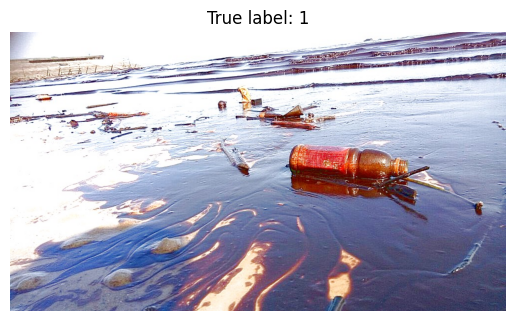

In [46]:
# Path to your image and its true label
image_path = r'D:\my_space\mifi_ml\hakaton1\final dataset used for oil spill\dataset-final\dataset\test\Oil Spill\AUG_oil_spill00160.jpg'  # Replace with your image path
true_label = 1 
plt.imshow(Image.open(image_path))
plt.axis('off')  # Hide the axis
plt.title(f"True label: {true_label}")
plt.show() 




In [47]:
processed_image = load_and_preprocess_image(image_path)
prediction = model.predict(processed_image)
predicted_class = (prediction > 0.5).astype("int32")  
print("Predicted class:", predicted_class[0][0])

1/1 [==============================] - 0s 15ms/step
Predicted class: 1


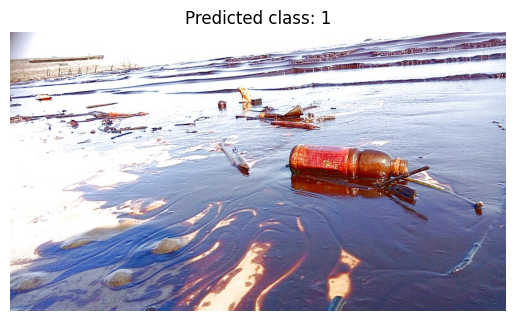

In [48]:
# Display the image
plt.imshow(Image.open(image_path))
plt.axis('off')  # Hide the axis
plt.title(f"Predicted class: {predicted_class[0][0]}")
plt.show()